In [1]:
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
ECG_trn = pickle.load(open('ECG5000/ECG5000_train.pickle', "rb"), encoding='latin1')
ECG_vld = pickle.load(open('ECG5000/ECG5000_validation.pickle', "rb"), encoding='latin1')

In [4]:
X_trn = np.delete(ECG_trn, 0, axis = 1)
X_vld = np.delete(ECG_vld, 0, axis = 1)
y_trn = ECG_trn[:, 0].reshape(-1)
y_vld = ECG_vld[:, 0].reshape(-1)


In [5]:
print(y_trn.shape)
print(X_trn.shape)
print(X_vld.shape)
print(y_vld.shape)

(500,)
(500, 140)
(1500, 140)
(1500,)


In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_trn)
X_vld_scaled = scaler.fit_transform(X_vld)

In [7]:
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_trn))

In [8]:
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_vld_scaled.shape[0]}")

Number of features: 140
Number of classes: 5
Training set size: 500
Validation set size: 1500


In [9]:
X_train_scaled.shape

(500, 140)

In [10]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(140,)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])



In [11]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
             loss = loss_function,
             metrics = ['accuracy']
             )

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_trn),
    y=y_trn
)



class_weight_dict = dict(zip(np.unique(y_trn), class_weights))

history = model.fit(
    X_train_scaled, y_trn,
    validation_data=(X_vld_scaled, y_vld),
    epochs=150,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1180 - loss: 1.9481 - val_accuracy: 0.1340 - val_loss: 2.0499
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1723 - loss: 1.9102 - val_accuracy: 0.1873 - val_loss: 1.9177
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1908 - loss: 1.8280 - val_accuracy: 0.2480 - val_loss: 1.8157
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2034 - loss: 1.7911 - val_accuracy: 0.3033 - val_loss: 1.7466
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2669 - loss: 1.6042 - val_accuracy: 0.3667 - val_loss: 1.6771
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2662 - loss: 1.5919 - val_accuracy: 0.4180 - val_loss: 1.6087
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3348 - loss: 1.4523 - val_accuracy: 0.4833 - val_loss: 1.5452
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3320 - loss: 1.4961 - val_accuracy: 0.5360 - 

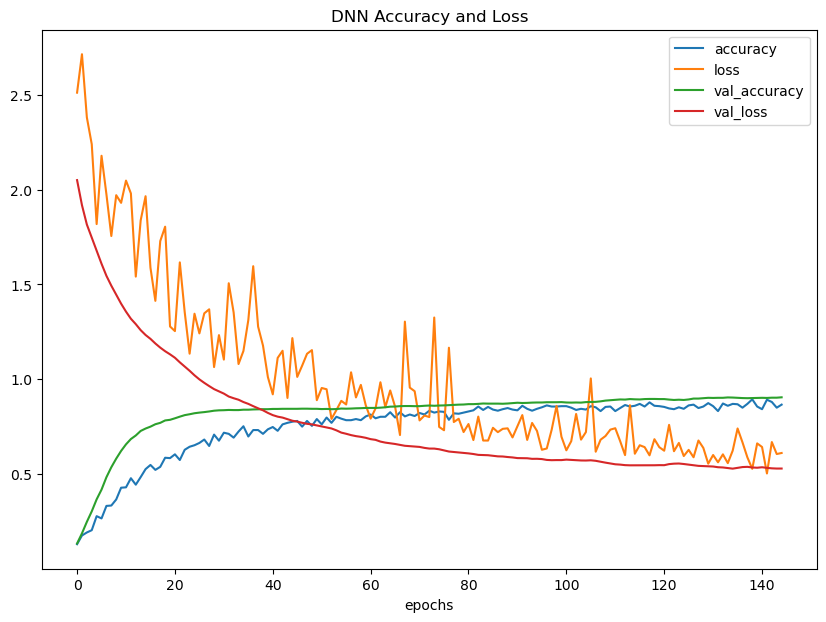

In [14]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs", title='DNN Accuracy and Loss');

In [15]:
model.evaluate(X_train_scaled, y_trn)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.2942 


[0.36929965019226074, 0.9480000138282776]

In [16]:
model.evaluate(X_vld_scaled, y_vld)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9666 - loss: 0.2974 


[0.5285095572471619, 0.903333306312561]

In [17]:
y_pred_proba = model.predict(X_vld_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [18]:
accuracy = accuracy_score(y_vld, y_pred)
precision = precision_score(y_vld, y_pred, average='macro')
recall = recall_score(y_vld, y_pred, average='macro')
f1 = f1_score(y_vld, y_pred, average='macro')
auroc = roc_auc_score(y_vld, y_pred_proba, average='macro', multi_class='ovr')
conf_matrix = confusion_matrix(y_vld, y_pred)

In [19]:
print("Accuracy: {:.4f}".format(accuracy))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1 Score (macro): {:.4f}".format(f1))
print("AUROC (macro, ovr): {:.4f}".format(auroc))
print("Confusion Matrix:")
print(conf_matrix)
cf_matrix = conf_matrix

Accuracy: 0.9033
Precision (macro): 0.6020
Recall (macro): 0.6429
F1 Score (macro): 0.6188
AUROC (macro, ovr): 0.8901
Confusion Matrix:
[[771   3   2   4   1]
 [  7 519  24  36   4]
 [  5   6  25   5   2]
 [  2  25   9  37   2]
 [  2   2   1   3   3]]


Text(50.722222222222214, 0.5, 'True Labels')

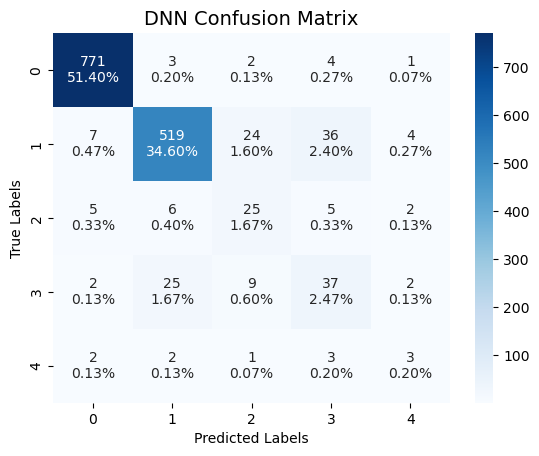

In [20]:
import seaborn as sns

plt.figure(dpi=100)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.title("DNN Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')